In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
            'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]
                            }}

In [5]:
cs_phase = {}
for basis in orbitals:
    cs_phase[basis] = {}
    for s in orbitals[basis]:
        cs_phase[basis][s] = [np.int32((-1)**v[2]) for v in orbitals[basis][s]]
        # cs_phase[basis][s] = []
        # for v in orbitals[basis][s]:
        #     if v[1] != 1:
        #         cs_phase[basis][s].append(1)
        #     else:
        #         cs_phase[basis][s].append(0)
# np.outer(np.array([1, -1, 1, 0]), np.array([1, -1, -1, -1]))

In [6]:
device = 'cpu'

In [7]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 4
# frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

# kmesh = [15,15,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/fock_{i}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/overlap_{i}.npy") for i in range(START, STOP)]

kmesh = [8,8,1]
kfock = [1/kmesh[0]*np.load(f"{root}/c2/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [1/kmesh[0]*np.load(f"{root}/c2/over_{i}_881.npy") for i in range(START, STOP)]


# kmesh = [12,12,1]
# kmesh = [1,1,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/fock_{i-1}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/overlap_{i-1}.npy") for i in range(START, STOP)]

for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

# for ifr in range(len(frames)):
#     line = np.concatenate([cs_phase[ORBS][s] for s in frames[ifr].numbers])
#     cs = np.outer(line, line)
#     for ik in range(len(kfock[ifr])):
#         kfock[ifr][ik] = kfock[ifr][ik]*cs
#         kover[ifr][ik] = kover[ifr][ik]*cs

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, 
                               fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                               overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)
# dataset_o = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = [kover[ifr][:] for ifr in range(len(frames))] , device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

# Targets

In [8]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = device, cutoff = cutoff, all_pairs = all_pairs, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [9]:
cutoff = None
# target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)
target_blocks_c, target_coupled_blocks_c = get_targets(dataset, cutoff = 6, device = device)

# target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
# target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')

# Features

In [10]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': 6,
               'max_radial': 4,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                      kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 4, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([362, 1, 4]) 1
torch.Size([716, 1, 4]) 2
torch.Size([362, 3, 4]) 1
torch.Size([716, 3, 4]) 2
torch.Size([362, 5, 4]) 1
torch.Size([716, 5, 4]) 2
torch.Size([362, 7, 4]) 1
torch.Size([716, 7, 4]) 2
torch.Size([362, 9, 4]) 1
torch.Size([716, 9, 4]) 2


In [11]:
hfeat_train = hfeat 
target_train = target_coupled_blocks

In [12]:
random_feat = metatensor.random_uniform_like(hfeat_train)

In [13]:
from metatensor import slice as mts_slice 
hfeat0 = mts_slice(hfeat, axis = 'samples', labels=Labels(['structure'], values = np.array([[0]])))
hfeat2 = mts_slice(hfeat, axis = 'samples', labels=Labels(['structure'], values = np.array([[2]])))

# Train

## Ridge regression

In [56]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [76]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = True)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [77]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
                                  target_blocks = target_coupled_blocks_c,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_c,
                                                                         set_bias = True)
print(loss_ridge_bias)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares 

tensor(0.0020)


## Torch

In [12]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [13]:
from mlelec.models.linear import LinearModelPeriodic

In [14]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [20]:
def train_model(model, optimizer, loss_func = 'kspace', scheduler = None, nepoch = 1000, dataset = None, 
                target_kspace=None, kpts=None, batch_size=None):
    losses = []
    seed = 1321341
    np.random.seed(seed)
    from copy import deepcopy
    kpts_ = deepcopy(kpts)
    for epoch in range(nepoch):
        
        model.train(True)
        # def closure():
        #     optimizer.zero_grad()
        #     pred = model.forward()
        #     loss = L2_loss(pred, target_train)
        #     # loss = torch.linalg.norm(rmat - matrices)**2
        #     loss.backward()
        #     return loss
    
        # optimizer.step(closure)
        # train_loss = closure().item()
        #ADAM 
        optimizer.zero_grad()
        # pred = model()
        # target.append(data['output'])
        # train_pred.append(pred)
        
        if loss_func == 'kspace':
            # batch over kpts
            epoch_loss = 0
            if batch_size is not None:
                for ifr in range(len(kpts)):
                    shuffled_kpt_idx = np.random.permutation(len(kpts[ifr]))
                    nbatch = np.int32(np.ceil(len(kpts[ifr]) / batch_size))
                    # print(len(kpts[ifr]), nbatch)
                    for ibatch in range(nbatch):
                        # print(ibatch, ifr)
                        pred = model()
                        kpts_idx = shuffled_kpt_idx[ibatch*batch_size:(ibatch+1)*batch_size]
                        loss = L2_kspace_loss(pred, [target_kspace[ifr][kpts_idx]], dataset, cg = CG, 
                                              kpts = [np.asarray(kpts[ifr])[kpts_idx].tolist()], desired_ifr = ifr)
                        
                        loss.backward(retain_graph = True)
                        optimizer.step()
                        # train_loss = loss.item()
                        epoch_loss+=loss
                    losses.append(epoch_loss.item())
                    if scheduler is not None:
                        scheduler.step(epoch_loss)      
            else:
                for ifr in range(len(kpts)):
                    pred = model()
                    loss = L2_kspace_loss(pred, [target_kspace[ifr]], dataset, cg = CG, 
                                          kpts = [kpts[ifr]], desired_ifr = ifr)
                    
                    loss.backward(retain_graph = True)
                    optimizer.step()
                    epoch_loss += loss
                    losses.append(epoch_loss.item())
                    if scheduler is not None:
                        scheduler.step(epoch_loss)

        #     loss = L2_kspace_loss(pred, target_kspace, dataset, cg = CG, kpts = kpts)
        #     train_loss = loss.item()
        #     loss.backward()
        #     optimizer.step()
        else:
            loss = L2_loss(pred, target_train)
            train_loss = loss.item()
            loss.backward()
            optimizer.step()
            losses.append(train_loss)
        
        # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
        # print(train_loss - epoch_loss)
        # losses.append(train_loss)
            if scheduler is not None:
                scheduler.step(loss)
    
            # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss on all blocks {epoch_loss.item()}")
        #     # validate 
        #     valpred = model.predict(hfeat_test, target_test)
        #     if loss_func == 'kspace':
        #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
        #     else:
        #         val_loss = L2_loss(valpred, target_test)
            
        #     print(f"Epoch {epoch} val loss {val_loss}")

    return model, losses

In [49]:
def normalize_numbers(numbers, MIN, MAX):
    min_value = min(numbers)
    max_value = max(numbers)
    
    # Calculate the range of the original values
    original_range = max_value - min_value
    
    # Calculate the range of the desired values
    desired_range = MAX - MIN
    
    # Normalize each number
    normalized_numbers = []
    for num in numbers:
        # Scale the number to the desired range
        normalized_num = ((num - min_value) / original_range) * desired_range + MIN
        normalized_numbers.append(normalized_num)
    
    return normalized_numbers

Initialize learning rate according to features norm: kind of works

In [25]:
model = LinearModelPeriodic(twocfeat = hfeat_train, 
                            target_blocks = target_train,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 64, 
                            nlayers = 2, 
                            train_kspace = True)

# model = model.double()
losses = []
para = {}
grad = {}
for key in model.model:
    for module in model.model[key].children():
        for m in module.children():
            torch.nn.init.constant_(m.weight, 1.0)
pred0 = model()
norms = np.array([torch.norm(b.values).item() for k, b in pred0.items()])
norms /= norms.max()
model = LinearModelPeriodic(twocfeat = hfeat_train, 
                            target_blocks = target_train,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 64, 
                            nlayers = 2, 
                            train_kspace = True)

# model = model.double()
losses = []
para = {}
grad = {}
optimizers = []
schedulers = []
# max_init_lr = 1e-2
# min_init_lr = 1e-3
nepoch = 10000
# final_lr = 1e-7
for i, key in enumerate(model.model):
# for i, (lr, key) in enumerate(zip(normalize_numbers(norms, min_init_lr, max_init_lr), model.model)):
    # print(lr)
    optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = norms[i]*1e-2))
    # optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = lr))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor=0.8, patience=50, verbose=True))
    # lambda_func = lambda epoch: 1 - (epoch / (nepoch - 1)) * (1 - final_lr / lr) # linear
    # lambda_func = lambda epoch: (final_lr/lr) ** (1/(nepoch - 1)) # exp
    # schedulers.append(torch.optim.lr_scheduler.LambdaLR(optimizers[-1], lambda_func))

Use RMSProp

In [345]:
model = LinearModelPeriodic(twocfeat = hfeat_train, 
                            target_blocks = target_train,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 64, 
                            nlayers = 5, 
                            train_kspace = True)

model = model.double()
losses = []
para = {}
grad = {}
optimizer = torch.optim.RMSprop(model.parameters(), lr = 5e-3, alpha = 0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=50, verbose=True)

Precompute phases for Fourier Transforms

In [51]:
H_T_ = blocks_to_matrix(target_blocks, dataset)
phases = {}
for ifr in range(len(kpts_train)):
    T_list = torch.from_numpy(np.array(list(H_T_[ifr].keys()), dtype = np.float64))
    k = torch.tensor(kpts_train[ifr])
    phases[ifr] = torch.exp(2j * np.pi * torch.tensordot(T_list, k, dims = ([-1], [-1])))

/home/pegolo/Software/my_mlelec/src/mlelec/utils/pbc_utils.py:346: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  out_blocks.append(TensorBlock(
/home/pegolo/Software/my_mlelec/src/mlelec/utils/pbc_utils.py:356: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  return TensorMap(Labels(blocks.keys.names + ["cell_shift_a", "cell_shift_b", "cell_shift_c"], np.asarray(out_block_keys)), out_blocks)


RuntimeError: both inputs should have same dtype

In [140]:
model = LinearModelPeriodic(twocfeat = hfeat_train, 
                            target_blocks = target_train,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 128, 
                            nlayers = 1,
                            train_kspace = True)

model = model.double()
losses = []
para = {}
grad = {}
nepoch = 4000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-2))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 150, verbose=True))

In [141]:
# kpts_train = [[[0.,0.,0.], [0.,8.3333e-2,0.]]]#, [[0.,0.,0.]], [[0.,0.,0.]]]
kpts_train = [dataset.cells[ifr].get_scaled_kpts(dataset.cells[ifr].make_kpts(dataset.kmesh[ifr]))[:].tolist() for ifr in range(len(dataset.structures))]
# print(kpts_train)
nk = len(kpts_train[0])
target_kspace = [x[:nk] for x in dataset.fock_kspace]
# m = train_model(model, optimizer, nepoch = 20000, dataset = dataset, target_kspace = target_kspace, kpts = kpts_train, scheduler = scheduler, batch_size = None)

In [142]:
seed = 1
np.random.seed(seed)
kpts_ = torch.tensor(kpts_train).to(device)

# nepoch = 10000

new_sched = True
# epoch = 2000
for epoch in range(nepoch):
    # epoch = epoch_+2000
    
    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    # optimizer.zero_grad()
    
    epoch_loss = 0
    pred = model()
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 3000:
        all_losses, tot_loss = L2_loss(pred, target_coupled_blocks_c, loss_per_block = True)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        for ik, loss in enumerate(all_losses):
            loss.backward(retain_graph = True)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
        epoch_loss += tot_loss
        losses.append(epoch_loss.item())
    
        # for ik, (key, loss) in enumerate(model.model):
        
    else:
        if new_sched:
            pred_before_k = pred.copy()
            
            for s, o in zip(schedulers, optimizers):
                s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.8, patience = 100, verbose=True)
            new_sched = False
        
        loss = L2_kspace_loss(pred, 
                              target_kspace, 
                              dataset, 
                              cg = CG, 
                              kpts = kpts_)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        loss.backward(retain_graph = True)
        epoch_loss += loss
        losses.append(epoch_loss.item())
    
        for ik, key in enumerate(model.model):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss)
        
    # optimizer.step()
    # scheduler.step(epoch_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss.item():>15.10f}, train loss per prediction {np.sqrt(epoch_loss.item())/n_predictions:>6.5e}")

        for key in model.model:
            if key not in para:
                para[key] = []
                grad[key] = []
            for param in model.model[key].parameters():
                param
                grad[key].append(param.grad.norm().item())
                para[key].append(param.norm().item())

    #     # validate 
    #     valpred = model.predict(hfeat_test, target_test)
    #     if loss_func == 'kspace':
    #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
    #     else:
    #         val_loss = L2_loss(valpred, target_test)
        
    #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks 1400.9939058158, train loss per prediction 2.09105e-03
Epoch      10, train loss on all blocks  504.7855399907, train loss per prediction 1.25516e-03
Epoch      20, train loss on all blocks  168.2699780021, train loss per prediction 7.24687e-04
Epoch      30, train loss on all blocks   28.6978726452, train loss per prediction 2.99276e-04
Epoch      40, train loss on all blocks    4.2335162937, train loss per prediction 1.14947e-04
Epoch      50, train loss on all blocks    6.1534727154, train loss per prediction 1.38582e-04
Epoch      60, train loss on all blocks    4.1367689470, train loss per prediction 1.13626e-04
Epoch      70, train loss on all blocks    1.9363860223, train loss per prediction 7.77397e-05
Epoch      80, train loss on all blocks    1.3427073566, train loss per prediction 6.47348e-05
Epoch      90, train loss on all blocks    1.3345500950, train loss per prediction 6.45378e-05
Epoch     100, train loss on all blocks    1.24603

Exception ignored in: <function Labels.__del__ at 0x7f90c950a980>
Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/metatensor/labels.py", line 380, in __del__
    def __del__(self):

KeyboardInterrupt: 


Epoch 03239: reducing learning rate of group 0 to 6.4000e-03.
Epoch    3240, train loss on all blocks    0.0152022150, train loss per prediction 6.88812e-06
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_135503/2935665861.py", line 44, in <module>
    loss = L2_kspace_loss(pred,
          ^^^^^^^^^^^^^^^^^^^^
  File "/home/pegolo/Software/my_mlelec/src/mlelec/metrics.py", line 29, in L2_kspace_loss
    pred_real = blocks_to_matrix(pred, dataset, cg = cg)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pegolo/Software/my_mlelec/src/mlelec/utils/pbc_utils.py", line None, in blocks_to_matrix
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [82]:
from mlelec.utils.pbc_utils import blocks_to_matrix

In [83]:
def reconstruct(pred, dataset):
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in dataset.overlap_realspace[ifr]:
                reconstructed_S[ifr][T] = dataset.overlap_realspace[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in dataset.overlap_realspace[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = dataset.overlap_realspace[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [143]:
rH_r, rS_r = reconstruct(pred_before_k, dataset)
rH_k, rS_k = reconstruct(pred, dataset)

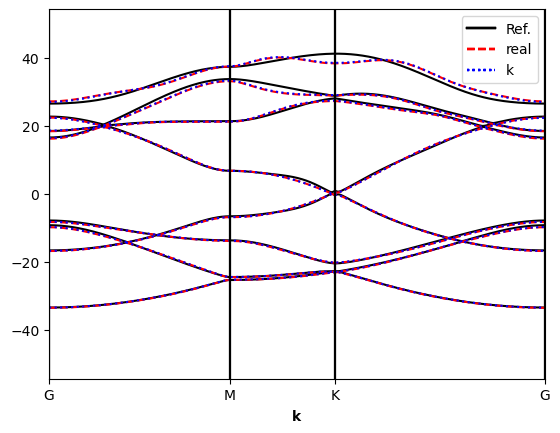

In [144]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'k')
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_r, rH_k], [rS_r, rS_k], ['red', 'blue'], ['--', ':'], [1, 1], ['real', 'k']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):

    realfock_cutoff = np.asarray(list(H[0].values()))
    realover_cutoff = np.asarray(list(S[0].values()))
    R_vec_rel = [list(T) for T in H[0]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, [8,8,1], 
                              factor = factor,
                              R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



Text(0, 0.5, 'Loss')

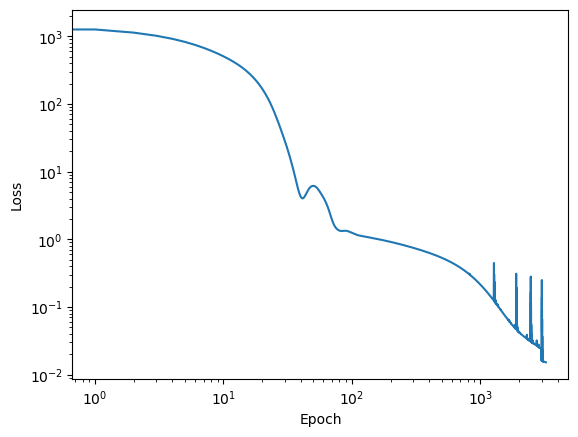

In [145]:
plt.loglog(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Parameter norm')

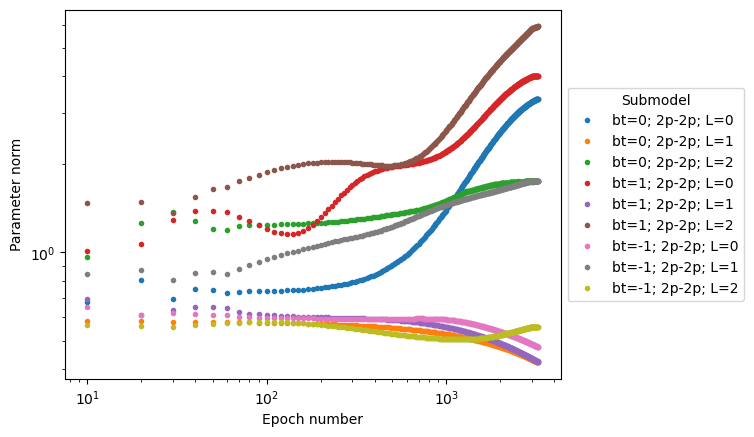

In [146]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()

for key in para:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 2 and l2 == 1:
        ax.loglog(np.arange(len(para[key]))*10, para[key], '.', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(title = 'Submodel', loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Parameter norm')

Text(0, 0.5, 'Gradient norm')

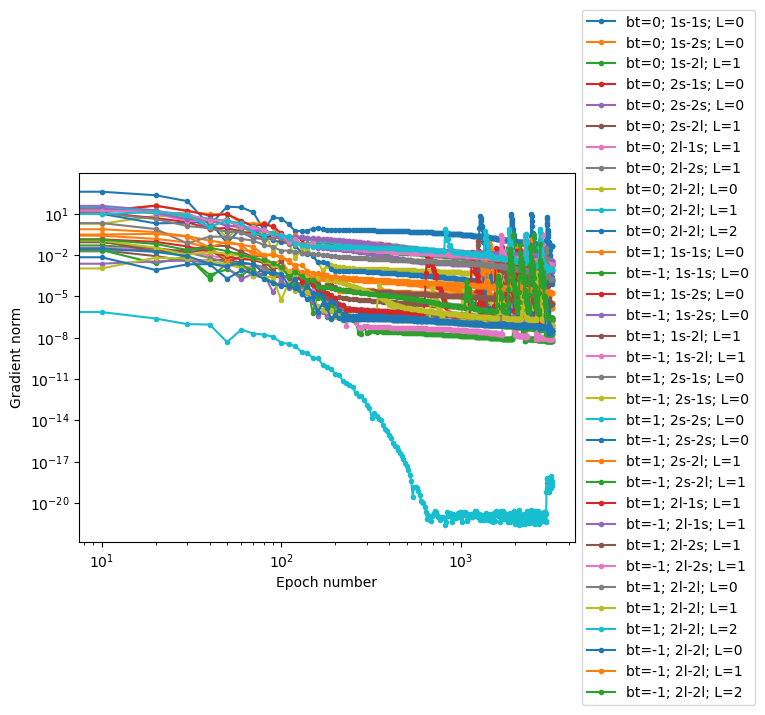

In [147]:
o = {0: 's', 1: 'l'}

fig, ax = plt.subplots()

for key in grad:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    ax.loglog(np.arange(len(grad[key]))*10, grad[key], '.-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Gradient norm')

In [150]:
weights = {}
for i, p in enumerate(model.parameters()):
    # if i//2 not in weights:
        # weights[i//2] = {}
        # weights[i//2][0] = p.data
    # else:
        # weights[i//2][1] = p.data
    weights[i] = p.data

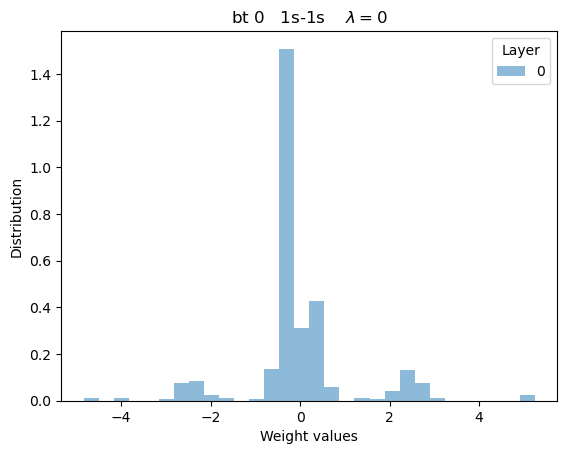

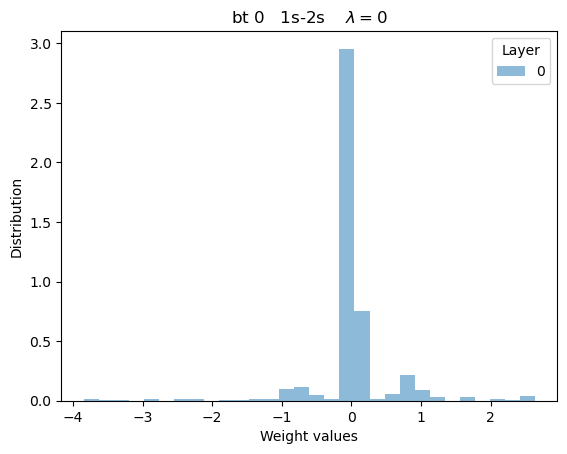

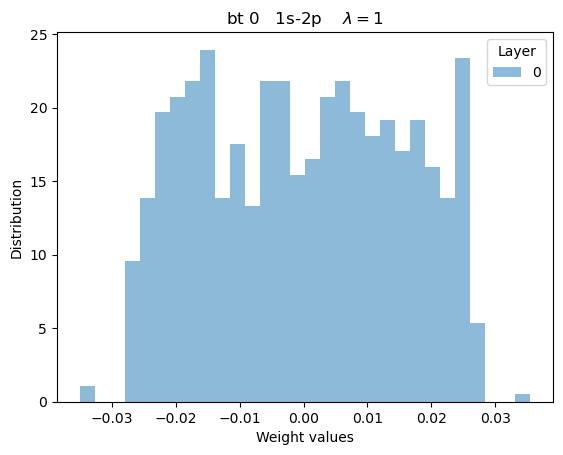

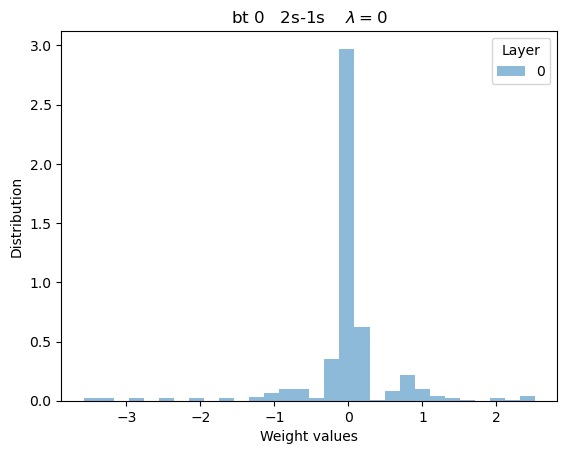

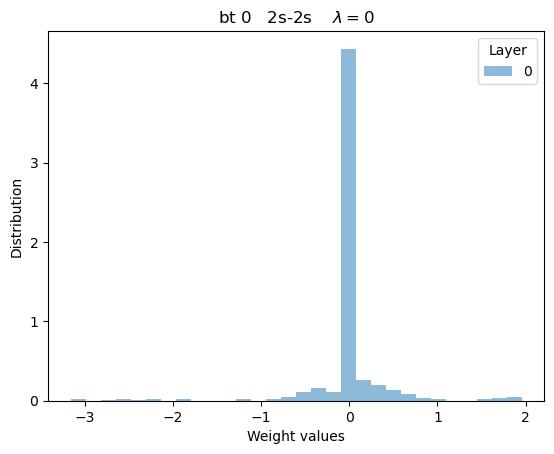

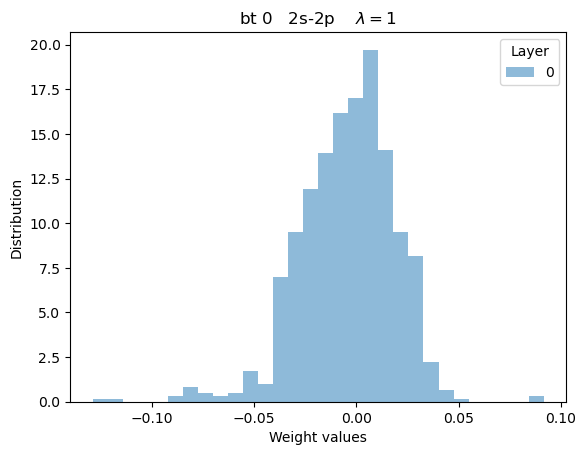

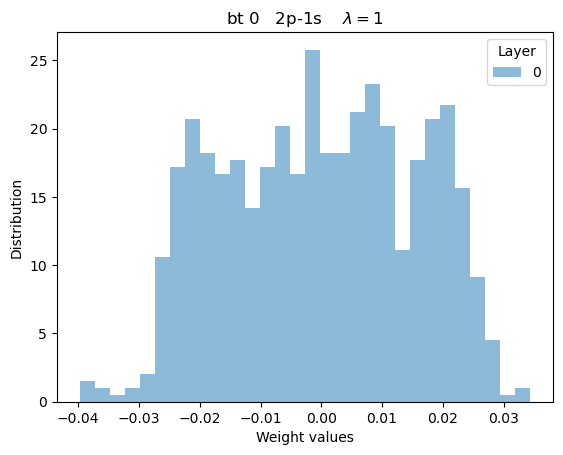

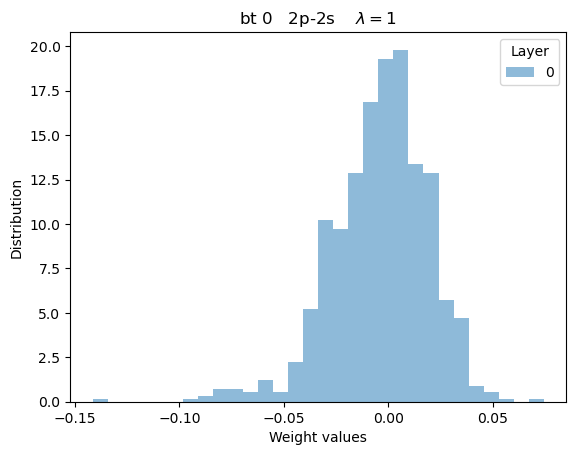

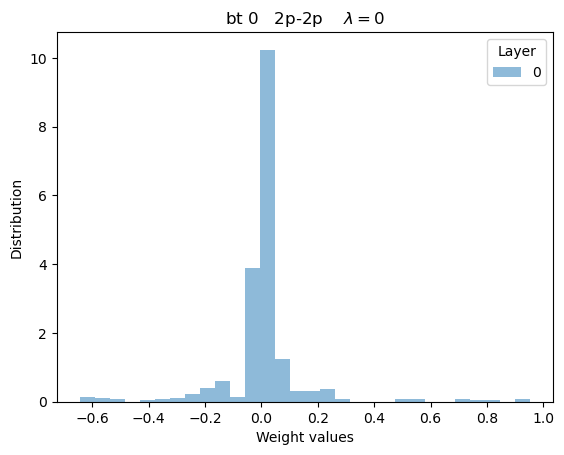

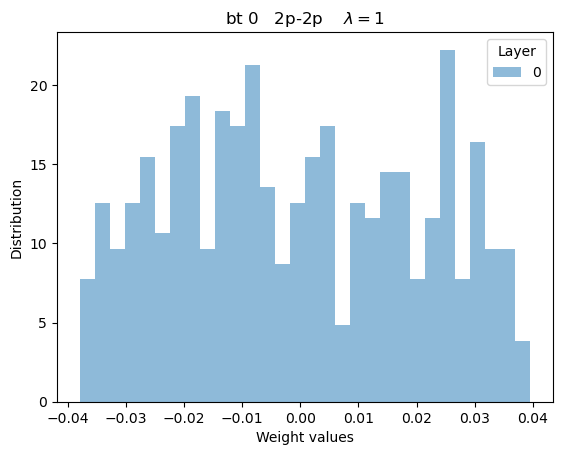

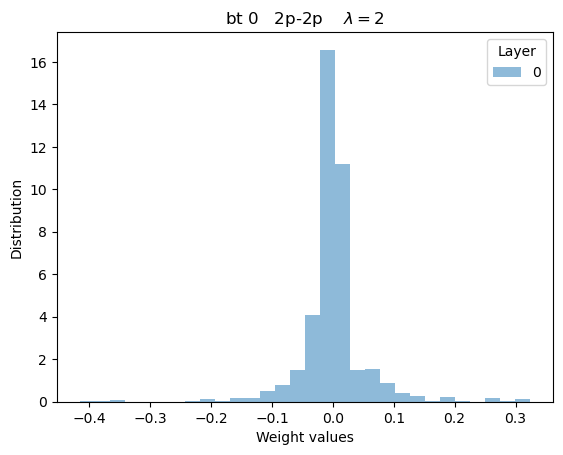

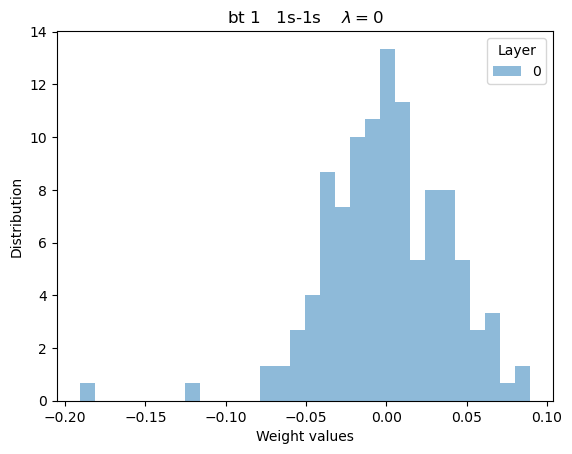

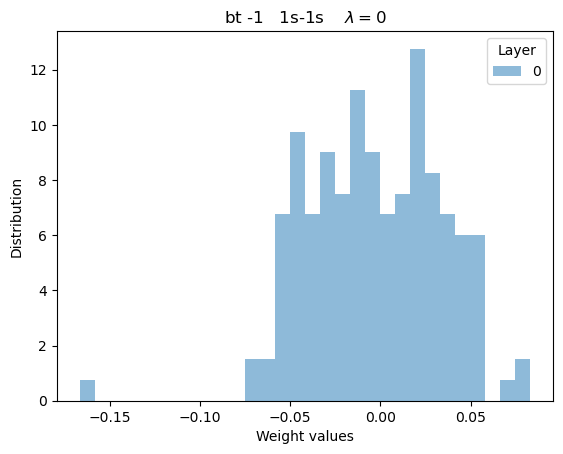

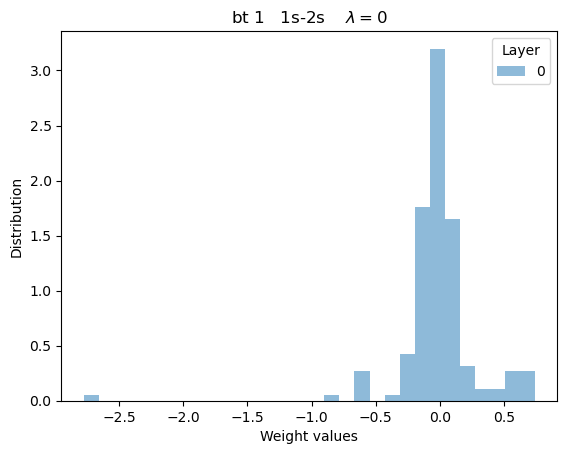

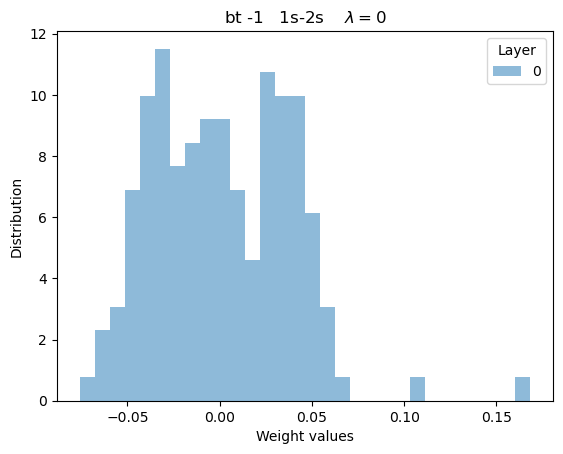

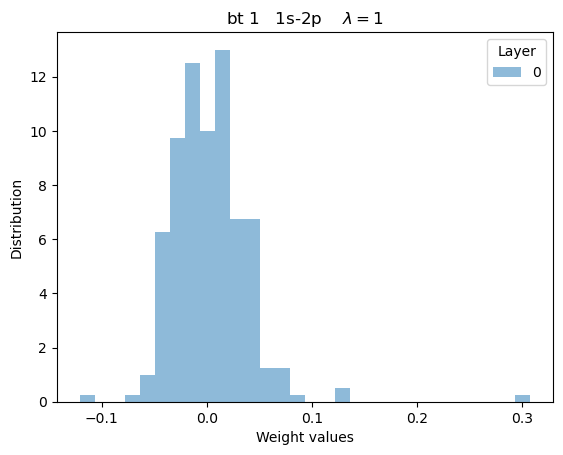

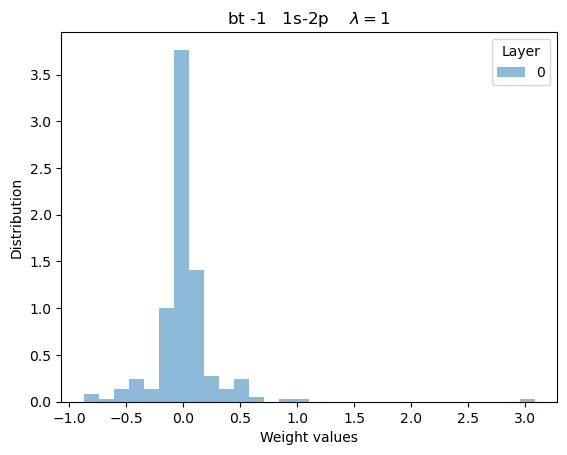

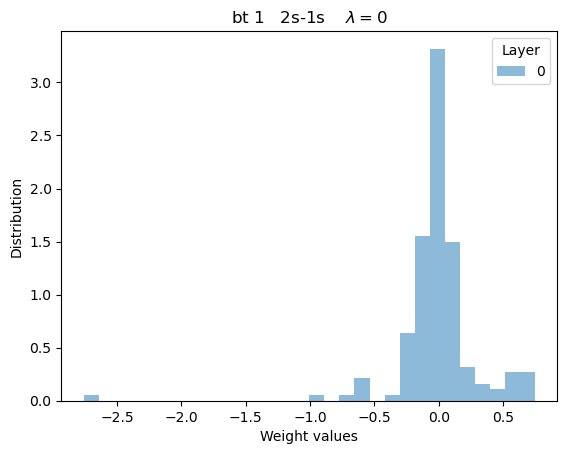

In [152]:
orb_labels = {0: 's', 1: 'p', 2: 'd'}
for i in range(18):
    fig, ax = plt.subplots()
    bt, _, n0, l0, _, n1, l1, L = pred.keys[i].values
    title = f'bt {bt}   {n0}{orb_labels[l0]}-{n1}{orb_labels[l1]}    $\lambda={L}$'
    # for j in range(1):
        # ax.hist(weights[i][j].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.hist(weights[i].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.set_title(title)
    ax.legend(title='Layer')
    ax.set_xlabel('Weight values')
    ax.set_ylabel('Distribution')

In [47]:
for k, b in hfeat.items():
    print()
    print(k)
    for sample in b.values:
        print('{:.3f} {:.3f}'.format(torch.norm(sample).item(), torch.var(sample).item()))


LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=0)
3.234 0.017
3.234 0.017

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.157 0.000
0.157 0.000

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
4.121 0.003
4.121 0.003

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
3.600 0.002
3.600 0.002

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.004 0.000
0.004 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
0.101 0.000
0.101 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
0.149 

In [51]:
target_kspace[0].shape

torch.Size([64, 10, 10])

In [71]:
for k, b in target_coupled_blocks.items():
    print()
    print(k)
    # for sample in b.values:
    #     print('{:.3e} {:.3e}'.format(torch.norm(sample).item(), torch.var(sample).item()))
    # print(np.mean([torch.norm(feature).item() for feature in b.values]), np.std([torch.norm(sample).item() for sample in b.values]))
    print('{:.3e} {:.3e}'.format(torch.norm(b.values, dim = 2).mean().item(), torch.norm(b.values, dim = 2).std().item()))


LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
1.102e+01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
1.733e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=1, l_j=0, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=0, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=1, L=0)
7.948e-01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2,

In [70]:
b.values.norm(dim=2).mean(dim=0)

tensor([3.2785e-11, 4.8314e-13, 1.6071e-16, 1.6817e-12, 1.4629e-16],
       device='cuda:0')

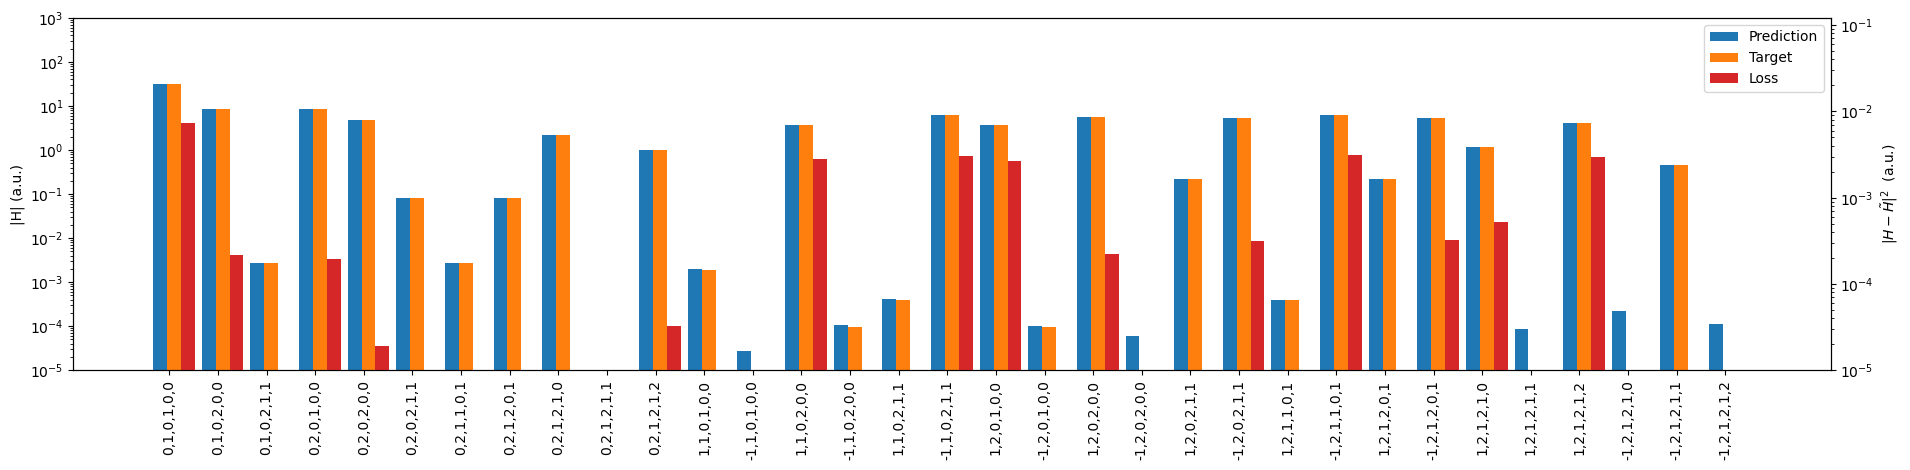

In [156]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_c, pred_before_k, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()